# NPMRDS data handling and processing

### *the code below helps calculate the daily, hourly average delay from National Performance Management Research Dara Set (NPMRDS): an archived speed and travel time dataset* 

## We separate the code into three parts for sharing
### 1. Needed packages 
### 2. Utility functions
### 3. Examples  

## 1. Needed packages

In [1]:
import pandas as pd
from pandas import *
import numpy as np
import os
from datetime import *
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import csv

## 2. Utility functions
Two datasets are used for delay calculation:
1. Averaged travel time in hour, including speed, travel time (seconds) and data density. 
2. TMC_identification.csv, which covers detailed information for road segment.

Data samples are shown in the next cell.

In [2]:
#the function below select the data given the selected time period, with start date "datetime1",
#end date "datetime2", starting time t1 (by hour) and ending time t2 (by hour).
def SelectDatabyTime(datetime1, datetime2, t1, t2, datafile):
    #get specific timestamp from the downloaded data 
    timelst = []
    for time in dt['measurement_tstamp']:
        if time not in timelst:
            dates = datetime.strptime(time,'%Y-%m-%d %H:%M:%S')
            if dates.date() >= datetime1.date() and dates.date() <= datetime2.date() and dates.time() >= t1 and dates.time() <= t2:
                timelst.append(time)
    
    #create a dict tt to store data based on the given date, hour 
    tt_dict = {}
    #add tmc id into direct
    #each tmc id denotes a specific road segment
    for tmcid in datafile['tmc_code']:
        if tmcid not in list(tt_dict.keys()):
            tt_dict[tmcid] = {}
    
    for tmcid in list(tt_dict.keys()):
        for time in timelst:
            tt_dict[tmcid][time] = 0
    
    #assign travel time to the dict        
    for row in range(len(dt['tmc_code'])):
        tmclst = list(tt_dict.keys())
        timelst = list(tt_dict[tmclst[0]].keys())
        if dt['measurement_tstamp'][row] in timelst:
            tt_dict[dt['tmc_code'][row]][dt['measurement_tstamp'][row]] = dt['travel_time_seconds'][row]
    return(tt_dict)     

#this function checks data for each road segment,
#here we set up a variable misnum for the number of accepted missing data 
#from each road segment, if number of missing data doesn't reach to the misnum,
#we treat it as 'available data' and return its road segment id
def CheckData(data_dict, misnum): 
    #get tmc id
    tmclst = list(data_dict.keys())
    #get selected time
    timelst = sorted(list(data_dict[tmclst[0]].keys()))
    avail_tmc_lst = []
    n = len(list(data_dict[tmclst[0]].keys()))
    if misnum >= n:
        print('Input error, given accepted missing number is out of data range')
    else:
        for tmc in tmclst:
            tt_lst = list(data_dict[tmc].values())
            if np.count_nonzero(tt_lst) >= n-misnum:
                avail_tmc_lst.append(tmc)
    return(avail_tmc_lst)

#this function get the travel time based on the available tmc list
def GetTT(avail_tmc_lst, dict_name):  
    tmclst = list(dict_name.keys())
    timelst = sorted(list(dict_name[tmclst[0]].keys()))
    avail_tt = {}
    for tmc in tmclst:
        if tmc in avail_tmc_lst:
            avail_tt[tmc] = []
            for time in timelst:
                avail_tt[tmc].append(dict_name[tmc][time])
    return(avail_tt)

#check the data from all the period of interest and keep the tmc id which is
#available within all the time
def GetAvailTT(daylst, hourlst, periodlst, datafile, misnum):    
    if len(daylst)%2!=0:
        print("Input error, missing of starting/ending date")
    if len(hourlst)%2!=0:
        print("Input error, missing of starting/ending hour")
    
    avail_dt = []
    tt_dict = {}
    for period in periodlst:
        tt_dict[period] = {}
    for i in range(int(len(daylst)/2)):
        tt_dict[periodlst[i]] = SelectDatabyTime(daylst[i*2], daylst[i*2+1], hourlst[0], hourlst[1], datafile)
        if i == 0:
            avail_dt = list(CheckData(tt_dict[periodlst[i]], misnum))
        else:
            avail_dt2 = CheckData(tt_dict[periodlst[i]], misnum)
            for tmc in avail_dt:
                #if the tmc id is not available in other time period
                if tmc not in avail_dt2:
                    avail_dt.remove(tmc) 
    
    avail_tt_dict = {}
    for period in periodlst:
        avail_tt_dict[period] = {}
        avail_tt_dict[period] = GetTT(avail_dt, tt_dict[period])
    return(avail_tt_dict)  

#this function calculate delay
#get free flow speed from TMC_Identification.csv
def GetFFLTT(pathfile, data_dict, traveltimedata):
    dt_tmc = pd.read_csv(pathfile)
    #get available tmc id calculated from GerAvailTT function
    for period in data_dict:
        tmclst = list(data_dict[period].keys())
        break
    #create a dict to store the road length of each tmc id in TMC_Identification.csv
    tmc_miles = {}
    for i in range(len(list(dt_tmc.index))):
        if dt_tmc['tmc'][i] in tmclst:
            tmc_miles[dt_tmc['tmc'][i]] = dt_tmc['miles'][i]
            
    #calculate the free flow travel time (FFLTT)
    #FFLTT = length/speed*3600 seconds
    # get free flow travel time from the datafile
    ffl_tt = {}
    for i in range(len(list(traveltimedata.index))):
        if traveltimedata['tmc_code'][i] in tmclst and traveltimedata['tmc_code'][i] not in list(ffl_tt.keys()):
            length = tmc_miles[traveltimedata['tmc_code'][i]]
            speed = traveltimedata['reference_speed'][i]
            #round up the results to two decimals
            ffl_tt[traveltimedata['tmc_code'][i]] = round(length/speed*3600, 2)
    return(ffl_tt)

#this function calculate delay
def cal_delay(tt_dict, ffl_dict):
    #calculate delay for each road segment of each road segment at different time
    #delay = current travel time - free flow travel time
    delay_dict = {}
    for period in tt_dict:
        delay_dict[period] = {}
        for tmc in tt_dict[period]:
            delay_dict[period][tmc] = []
            for i in range(len(tt_dict[period][tmc])):
                delay = round(tt_dict[period][tmc][i] - ffl_dict[tmc],3)
                delay_dict[period][tmc].append(delay)
    
    return(delay_dict)

#this function calculate delay for each tmc at different time period
def DelayAvgofTMC(delay_dict):
    delay_avg = {}
    for period in delay_dict:
        delay_avg[period] = {}
        for tmc in delay_dict[period]:
            delay_avg[period][tmc] = round(sum(delay_dict[period][tmc])/len(delay_dict[period][tmc]),3)
    return(delay_avg)

#this function calculated average delay of all tmc at different time period
def DelayAvg(delay_dict):
    delay_avg = {}
    for period in delay_dict:
        delay_avg[period] = []
        a = 0
        for tmc in delay_dict[period]:
            for i in range(len(delay_dict[period][tmc])):
                if a == 0:
                    delay_avg[period].append(delay_dict[period][tmc][i])
                else:
                    delay_avg[period][i] = delay_avg[period][i]+delay_dict[period][tmc][i]
            a = a+1
    for period in delay_avg:
        for i in range(len(delay_avg[period])):
            delay_avg[period][i] = round(delay_avg[period][i]/a, 3)
    
    return(delay_avg) 

def delay_plt(title, legendnote, delay_dict):
    #calculate the average
    delay_avg = DelayAvg(delay_dict)
    fig = plt.figure()
    ax = fig.add_axes([0.8, 0.8, 1, 1]) # main axes
    a = 0
    for period in delay_avg:
        x = list(range(len(delay_avg[period])))
        delay = delay_avg[period]
        #get length of interval
        interval = len(x)/7
        y = delay[(int(interval*2)):]
        y.extend(delay[:(int(interval*2))])
        #plot with different style
        if a == 1:
            ax.plot(x, y,'.-')
        elif a == 2:
            ax.plot(x, y,'r--')
        elif a == 3:
            ax.plot(x, y,'b:')
        else:
             ax.plot(x, y)
        a = a+1

    ax.set_title('Average delay '+ title)
    ax.set_xlabel('Day')
    #locate x axis for x_label
    x_loc = []
    for i in range(7):
        x_loc.append(int(i*interval))
    ax.set_xticks(x_loc)
    ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax.set_ylabel("Travel time (seconds)") 
    plt.grid()
    plt.legend(legendnote, loc='lower left', bbox_to_anchor=(1., 0.5))
    plt.show()


# 3. Examples

In [3]:
#Data format
#Average travel time dataset
dt = pd.read_csv('atbt/atbt.csv')
dt.head()

,tmc_code,measurement_tstamp,speed,average_speed,reference_speed,travel_time_seconds,data_density
0,114+08098,2019-11-02 00:00:00,24.00,47.0,39.0,12.32,A
1,114+08098,2019-11-02 06:00:00,24.00,54.0,39.0,12.32,A
2,114+08098,2019-11-02 08:00:00,32.43,45.0,39.0,9.11,A
3,114+08098,2019-11-02 09:00:00,29.38,42.0,39.0,10.06,A
4,114+08098,2019-11-02 10:00:00,28.83,39.0,39.0,10.25,A


In [4]:
# TMC_Identification.csv
# Metadata of each road segment
dt_tmc = pd.read_csv('atbt/TMC_Identification.csv')
dt_tmc.head()

,tmc,road,direction,intersection,state,county,zip,start_latitude,start_longitude,end_latitude,...,aadt_singl,aadt_combi,nhs,nhs_pct,strhnt_typ,strhnt_pct,truck,isprimary,active_start_date,active_end_date
0,114+08099,WESTERN AVE,NORTHBOUND,WALL ST,WA,KING,98121,47.61350,-122.34872,47.61406,...,617,617,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
1,114+08098,WESTERN AVE,NORTHBOUND,WA-99/BATTERY ST,WA,KING,98121,47.61272,-122.34739,47.61350,...,617,617,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
2,114-08547,5TH AVE,NORTHBOUND,LEE ST,WA,KING,98109,47.62451,-122.34756,47.63105,...,621,621,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
3,114-08546,5TH AVE,NORTHBOUND,MERCER ST,WA,KING,98109,47.61857,-122.34763,47.62451,...,553,405,1,100,0,100,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00
4,114-10503,S JACKSON ST,WESTBOUND,4TH AVE S,WA,KING,98104,47.59924,-122.31412,47.59920,...,512,255,1,70,0,0,0,1,2019-01-01 00:00:00-05:00,2020-01-01 00:00:00-05:00


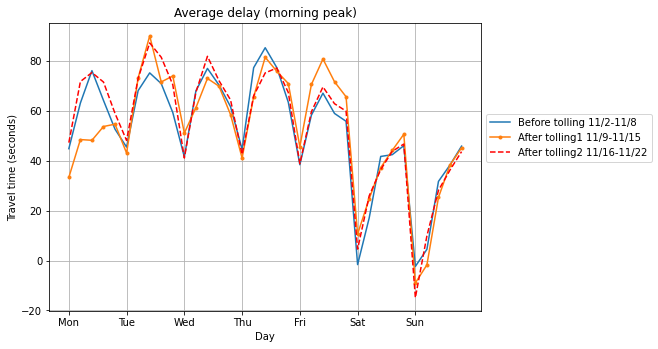

In [5]:
#define the starting date and ending date for each time period
#the input format should include the starting date and ending date 
#here we take before tolling and after tolling period of SR 99 tunnel in Washington
#the defined data follows the before/after tolling analysis in the FHWA project
#before tolling period
bt1 = datetime(2019,11,2,0,0)
bt2 = datetime(2019,11,8,0,0)
#after tolling period1
at11 = datetime(2019,11,9,0,0)
at12 = datetime(2019,11,15,0,0)
at21 = datetime(2019,11,16,0,0)
at22 = datetime(2019,11,22,0,0)

#define hour of day we want to include, 
#in this example, we choose morning peak 06:00-10:00
h1 = datetime(2019,11,2,6,0).time() 
h2 = datetime(2019,11,2,10,0).time()

day = [bt1, bt2, at11, at12, at21, at22]
hour = [h1, h2]

#define period name
pdlst = ['BT','AT1','AT2']

#get travel time data
TT_dict = GetAvailTT(day, hour, pdlst, dt, 5)

#get free flow travel time
FFLTT_dict = GetFFLTT('atbt/TMC_Identification.csv', TT_dict, dt)

#calculate delay
Delay_dict = cal_delay(TT_dict,FFLTT_dict)       

#plot delay
atbt_legend = ['Before tolling 11/2-11/8','After tolling1 11/9-11/15','After tolling2 11/16-11/22']
delay_plt('(morning peak)', atbt_legend, Delay_dict)